# Ensemble Model

The Ensemble Model used is a combination of Recurrent Neural Network (RNN), Long-Short-Term-Memory Network (LSTM) and Gated Recurrent Unit (GRU) to form a Stacked RNN-LSTM-GRU ensemble model.  

## 1. Import Libraries
Libraries needed for are imported in this step.

In [5]:
import pandas as pd
import numpy as np
import re
import gensim
import string
import nltk
import keras
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.layers import Embedding
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\navya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\navya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [14]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\navya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [16]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\navya\AppData\Roaming\nltk_data...


True

In [18]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\navya\AppData\Roaming\nltk_data...


True

## 2. Read Training Dataset
The training dataset used is the dataset downloaded from Kaggle that contains around 27k rows of Tweets with their sentiments labeled.

In [6]:
# read training dataset
train = pd.read_csv("train_dataset.csv", encoding = "unicode_escape")
print("Initial: ")
print(train.head())

Initial: 
                                               input    output  \
0  `` The implementation of these programs has ha...  negative   
1  InterContinental Hotels first-quarter global r...  negative   
2  ALEXANDRIA , Va. , March 15 -- Jaakko Vilo of ...   neutral   
3  Caterpillar: 3 lessons from an iconic brand ab...   neutral   
4  `` The rest of this week 's tapings of Jimmy K...   neutral   

                                         instruction  
0  What is the sentiment of this news? Please cho...  
1  What is the sentiment of this news? Please cho...  
2  What is the sentiment of this news? Please cho...  
3  What is the sentiment of this tweet? Please ch...  
4  What is the sentiment of this news? Please cho...  


## 3. Drop Rows with Missing Values
Rows that contain missing values are dropped to clean the dataset.

In [7]:
# drop rows with null values
train = train.dropna(axis = 0)

## 4. Preprocess Texts
The steps used to preprocess texts are as follows: <br>
a. Remove Links <br>
b. Remove Remove Emails <br>
c. Remove New Line Characters <br>
d. Remove Numbers <br>
e. Remove Emojis <br>
f. Remove Punctuations and Accents <br>
g. Remove Irrelevant Words (Length shorter or equal to 2 OR length greater or equal to 15) <br>
h. Remove Stopwords <br>
i. Tokenization <br>
j. Part-of-Speech (POS) Tagging <br>
k. Lemmatization <br>

In [19]:
stop_words = set(stopwords.words('english'))
def get_wordnet_pos(treebank_pos):
    if treebank_pos.startswith('J'):
        return wordnet.ADJ
    elif treebank_pos.startswith('V'):
        return wordnet.VERB
    elif treebank_pos.startswith('N'):
        return wordnet.NOUN
    elif treebank_pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def depure_data(data):
    # Remove URL
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)
    
    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

def sent_to_words(sentences):
    for sentence in sentences:
        # 1. Converts to lowercase
        # 2. Removes accents and punctuations
        # 3. Removes words shorter (<=) or longer (>=) than minimum length of 2 and maximum length of 15
        # 4. Removes numerical characters
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

def stopwords_lemmatize(data):
    # Remove stopwords
    data = " ".join([word for word in str(data).split() if word not in stop_words])
    
    # Apply tokenization
    data = nltk.word_tokenize(data)
    
    # Perform POS tagging
    data = nltk.pos_tag(data)
    
    # Perform lemmatization
    lemmatized_tokens = []

    for i in range(len(data)):
        word, pos = data[i]
        
        lemmatized_tokens.append(nltk.WordNetLemmatizer().lemmatize(word, get_wordnet_pos(pos)))
    
    data = " ".join(lemmatized_tokens)
    
    return data

temp = []
# Convert the values in the dataset to a list
data_to_list = train['input'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
data_words = list(sent_to_words(temp))
detokenized = []
for i in range(len(data_words)):
    detokenized.append(detokenize(data_words[i]))
data = []
for i in range(len(detokenized)):
    data.append(stopwords_lemmatize(detokenized[i]))
print(data[:5])

['implementation program negative impact earnings mr meiklejohn say', 'hotel first quarter global room revenue lag estimate', 'alexandria va march jaakko vilo turku finland develop panel press', 'caterpillar lesson iconic brand digital competition', 'rest week taping jimmy kimmel live cancel back foot']


## 5. Label Encoding
The label is encoded into 1 for positive, 0 for neutral and -1 for negative before it is one-hot encoded into the following structure: <br>
[neutral, positive, negative]

In [20]:
train['output'] = train['output'].map({"positive": 1, "neutral": 0, "negative": -1})
y = train['output'].to_numpy()
y = keras.utils.to_categorical(y, 3)
print(y[:5])

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


## 6. Feature Extraction
The feature vector or raw word vector is extracted by converting the texts into sequence of numbers. <br>
The maximum number of words that will be stored in the tokenizer is 5000 and the maximum length of the vector is 200, texts that are shorter than the maximum length will be padded with 0s. 

In [21]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
inputs = pad_sequences(sequences, maxlen=max_len)
print(inputs)

[[   0    0    0 ...   43  627    6]
 [   0    0    0 ...   51  869  117]
 [   0    0    0 ...  295 1740  620]
 ...
 [   0    0    0 ...    5   56 3833]
 [   0    0    0 ...   75 1362 1671]
 [   0    0    0 ...  133  122  146]]


## 7. Train Validation Split
The training dataset is split by 80% and 20% into train and validation set. 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(inputs, y, test_size = 0.2, random_state = 0)

## 8. Model Training
The models in this file are the three individual models, RNN, LSTM, GRU and the ensemble model, Stacked RNN-LSTM-GRU ensemble model. After each model is trained, the model is saved to a .h5 file so that the model can be loaded for prediction without training again and for training the meta-learner. 

### a. RNN

In [24]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 40, input_length=max_len))
model0.add(layers.SimpleRNN(125, kernel_regularizer=regularizers.l2(l=0.0001)))
model0.add(layers.Dropout(0.8))
model0.add(layers.Dense(10, activation='relu'))
model0.add(layers.Dense(3,activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model0.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model0.summary()

checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=8, bbatch_size=64, validation_data=(X_test, y_test),callbacks=[checkpoint0])
model0.save('RNN.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 40)           200000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 125)               20750     
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense (Dense)               (None, 10)                1260      
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 222,043
Trainable params: 222,043
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
437/437 [==============================]

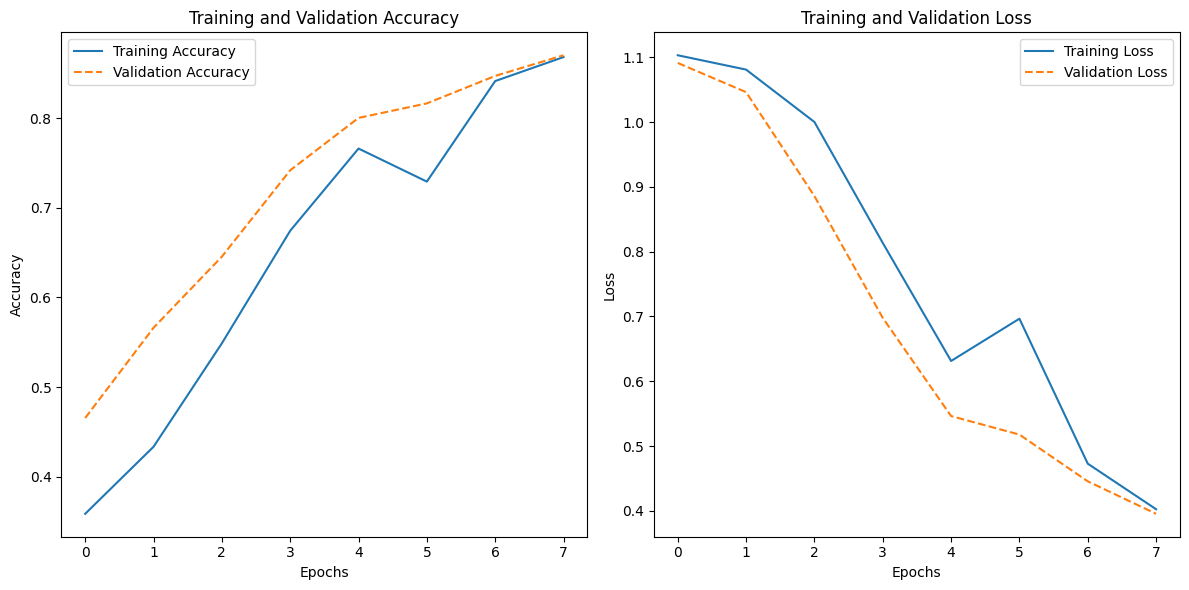

In [25]:
import matplotlib.pyplot as plt

# Extract the history data
history_dict = history.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### b. LSTM

In [26]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 40, input_length=max_len)) 
model1.add(layers.LSTM(20,dropout=0.9)) 
model1.add(layers.Dense(3,activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history2 = model1.fit(X_train, y_train, epochs=8, batch_size=64, validation_data=(X_test, y_test),callbacks=[checkpoint3])
model1.save('LSTM.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 40)           200000    
                                                                 
 lstm (LSTM)                 (None, 20)                4880      
                                                                 
 dense_2 (Dense)             (None, 3)                 63        
                                                                 
Total params: 204,943
Trainable params: 204,943
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
437/437 [==============================] - ETA: 0s - loss: 0.9314 - accuracy: 0.5454
Epoch 1: val_accuracy improved from -inf to 0.76186, saving model to best_model3.hdf5
437/437 [==============================] - 46s 100ms/step - loss: 0.9314 - accuracy: 0.5454 - val_loss: 0.6038 - val_accuracy: 0.76

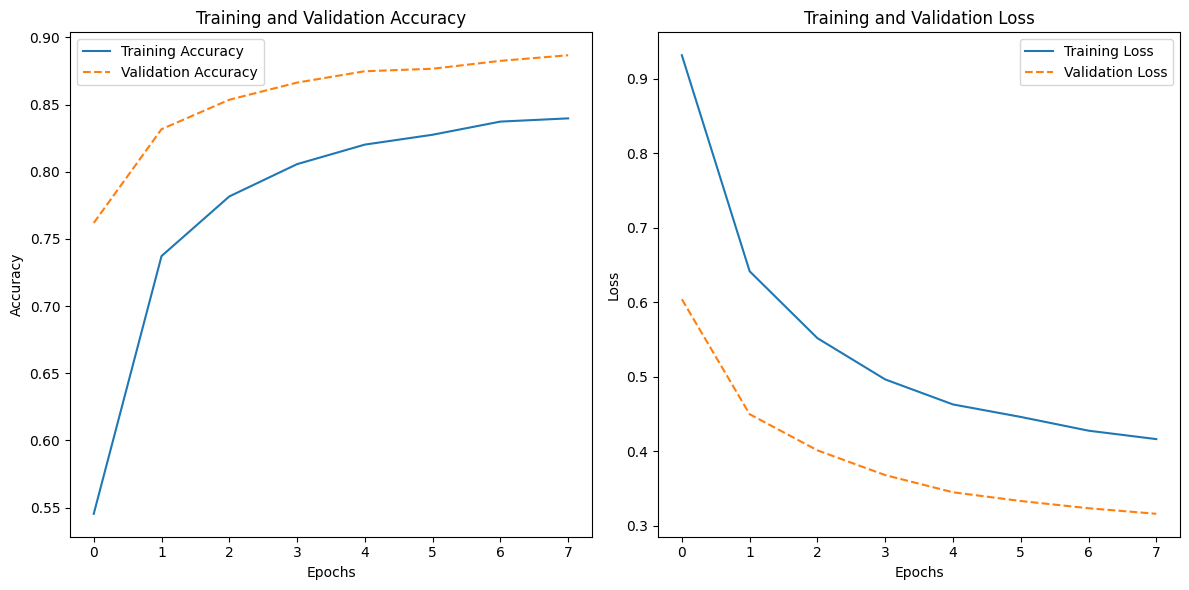

In [27]:
import matplotlib.pyplot as plt

# Extract the history data
history_dict = history2.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### c. GRU

In [28]:
model2 = keras.Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len)) 
model2.add(layers.GRU(10, kernel_regularizer=regularizers.l2(l=0.00001)))
model2.add(layers.Dropout(0.9))
model2.add(layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(l=0.00001)))
model2.add(layers.Dense(3, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history3 = model2.fit(X_train, y_train, epochs=8, batch_size=64, validation_data=(X_test, y_test),callbacks=[checkpoint2])
model2.save('GRU.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 40)           200000    
                                                                 
 gru (GRU)                   (None, 10)                1560      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 3)                 33        
                                                                 
Total params: 201,703
Trainable params: 201,703
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
437/437 [=============================

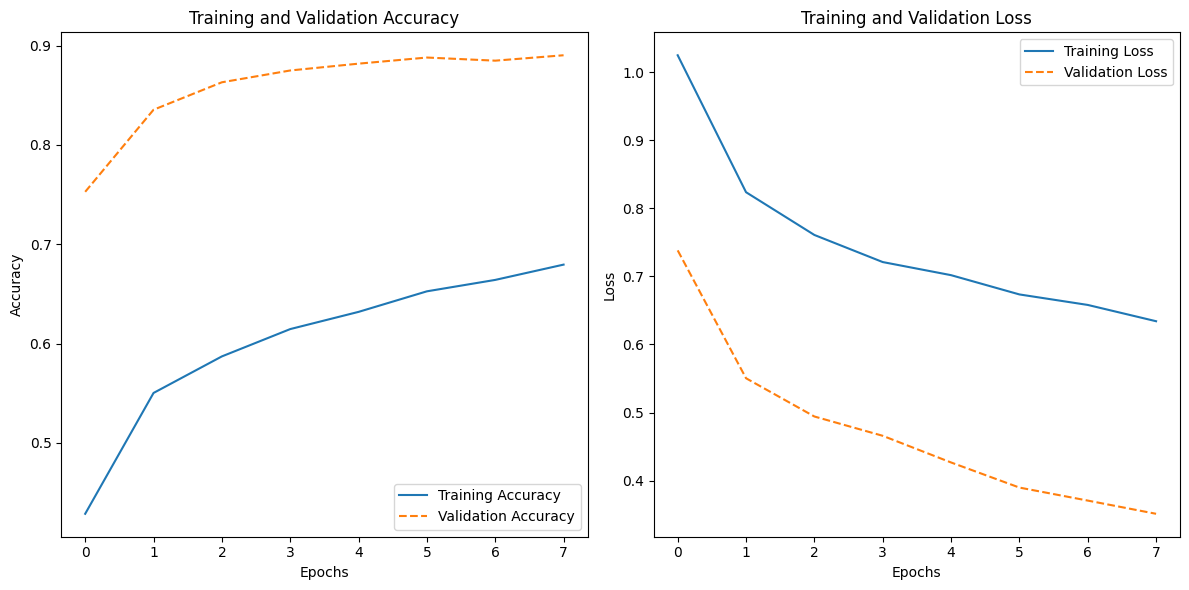

In [29]:
import matplotlib.pyplot as plt

# Extract the history data
history_dict = history3.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### d. Ensemble Model

i. Function to use the base-learners to predict the probabilities individually and stack the predictions made by the deep learning base-learners before flattening to a 2D array.

In [30]:
def stacked_dataset(members, inputX):
    stackX = None
    itr = 0
    for model in members:
        # predict the outputs using baselearners
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = np.dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

ii. Function to train the SVM meta-learner with the new inputs which are the stacked predictions from the base-learners together with the labels.

In [31]:
def fit_stacked_model_svm(members, inputX, inputy):
    # create dataset that contains the predicted probabilities from the baselearners
    stackedX = stacked_dataset(members, inputX)
    # fit meta-learner
    model = SVC(kernel='poly', C=0.00025)
    model.fit(stackedX, inputy)
    return model

members = []
model = load_model('RNN.h5')
members.append(model)
model = load_model('LSTM.h5')
members.append(model)
model = load_model('GRU.h5')
members.append(model)

sentiment = ['neutral', 'positive', 'negative']
y_train_transform = []
for y in y_train:
    y_train_transform.append(sentiment[np.around(y, decimals=0).argmax()])
# fit stacked model
modelSVM = fit_stacked_model_svm(members, X_train, y_train_transform)

iii. Function to train the LR meta-learner with the new inputs which are the stacked predictions from the base-learners together with the labels.

In [32]:
def fit_stacked_model_lr(members, inputX, inputy):
    # create dataset that contains the predicted probabilities from the baselearners
    stackedX = stacked_dataset(members, inputX)
    # fit meta-learner
    model = LogisticRegression(C=0.001, random_state=0)
    model.fit(stackedX, inputy)
    return model

members = []
model = load_model('RNN.h5')
members.append(model)
model = load_model('LSTM.h5')
members.append(model)
model = load_model('GRU.h5')
members.append(model)

sentiment = ['neutral', 'positive', 'negative']
y_train_transform = []
for y in y_train:
    y_train_transform.append(sentiment[np.around(y, decimals=0).argmax()])
# fit stacked model
modelLR = fit_stacked_model_lr(members, X_train, y_train_transform)

iv. Function to predict the output of data after training the meta-learners.

In [33]:
def stacked_prediction(members, model, inputX):
    # create dataset that contains the predicted probabilities from the baselearners
    stackedX = stacked_dataset(members, inputX)
    # predict the outputs using ensemble model
    yhat = model.predict(stackedX)
    return yhat

## 9. Model Evaluation
Each of the models are evaluated using accuracy, precision, recall and F1-score which are obtained from the classification report. 

### a. RNN

In [35]:
sentiment = ['neutral', 'positive', 'negative']

model0 = load_model('RNN.h5')

print(' RNN MODEL ')
print('===========')

print(" TEST ACCURACY ")
print("======================")
reviewTest = pd.read_csv("test_dataset.csv")
X_reviewTest = reviewTest['input']
y_reviewTest = reviewTest['output'].values.tolist()

X_reviewTest = X_reviewTest.values.tolist()
temp = []
for i in range(len(X_reviewTest)):
    temp.append(depure_data(X_reviewTest[i]))
data_words = list(sent_to_words(temp))
detokenized = []
for i in range(len(data_words)):
    detokenized.append(detokenize(data_words[i]))
data = []
for i in range(len(detokenized)):
    data.append(stopwords_lemmatize(detokenized[i]))
X_reviewTest = tokenizer.texts_to_sequences(data)
X_reviewTest = pad_sequences(X_reviewTest, maxlen=max_len)

y_predictReview = model0.predict(X_reviewTest)
predicted_sentiment_review = []
for y in y_predictReview:
    predicted_sentiment_review.append(sentiment[np.around(y, decimals=0).argmax()])
print(classification_report(y_reviewTest, predicted_sentiment_review))

 RNN MODEL 
 TEST ACCURACY 
12/12 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

    negative       0.92      0.90      0.91       117
     neutral       0.79      0.95      0.86       118
    positive       0.94      0.77      0.85       118

    accuracy                           0.87       353
   macro avg       0.88      0.87      0.87       353
weighted avg       0.88      0.87      0.87       353



### b. LSTM

In [36]:
sentiment = ['neutral', 'positive', 'negative']

model0 = load_model('LSTM.h5')

print(' LSTM MODEL ')
print('============')

print(" TEST ACCURACY ")
print("======================")
reviewTest = pd.read_csv("test_dataset.csv")
X_reviewTest = reviewTest['input']
y_reviewTest = reviewTest['output'].values.tolist()

X_reviewTest = X_reviewTest.values.tolist()
temp = []
for i in range(len(X_reviewTest)):
    temp.append(depure_data(X_reviewTest[i]))
data_words = list(sent_to_words(temp))
detokenized = []
for i in range(len(data_words)):
    detokenized.append(detokenize(data_words[i]))
data = []
for i in range(len(detokenized)):
    data.append(stopwords_lemmatize(detokenized[i]))
X_reviewTest = tokenizer.texts_to_sequences(data)
X_reviewTest = pad_sequences(X_reviewTest, maxlen=max_len)

y_predictReview = model0.predict(X_reviewTest)
predicted_sentiment_review = []
for y in y_predictReview:
    predicted_sentiment_review.append(sentiment[np.around(y, decimals=0).argmax()])
print(classification_report(y_reviewTest, predicted_sentiment_review))

 LSTM MODEL 
 TEST ACCURACY 
12/12 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

    negative       0.90      0.86      0.88       117
     neutral       0.83      0.88      0.86       118
    positive       0.91      0.89      0.90       118

    accuracy                           0.88       353
   macro avg       0.88      0.88      0.88       353
weighted avg       0.88      0.88      0.88       353



### c. GRU

In [37]:
sentiment = ['neutral', 'positive', 'negative']

model0 = load_model('GRU.h5')

print(' GRU MODEL ')
print('===========')


print(" TEST ACCURACY ")
print("======================")
reviewTest = pd.read_csv("test_dataset.csv")
X_reviewTest = reviewTest['input']
y_reviewTest = reviewTest['output'].values.tolist()

X_reviewTest = X_reviewTest.values.tolist()
temp = []
for i in range(len(X_reviewTest)):
    temp.append(depure_data(X_reviewTest[i]))
data_words = list(sent_to_words(temp))
detokenized = []
for i in range(len(data_words)):
    detokenized.append(detokenize(data_words[i]))
data = []
for i in range(len(detokenized)):
    data.append(stopwords_lemmatize(detokenized[i]))
X_reviewTest = tokenizer.texts_to_sequences(data)
X_reviewTest = pad_sequences(X_reviewTest, maxlen=max_len)

y_predictReview = model0.predict(X_reviewTest)
predicted_sentiment_review = []
for y in y_predictReview:
    predicted_sentiment_review.append(sentiment[np.around(y, decimals=0).argmax()])
print(classification_report(y_reviewTest, predicted_sentiment_review))

 GRU MODEL 
 TEST ACCURACY 
12/12 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

    negative       0.96      0.91      0.93       117
     neutral       0.79      0.97      0.87       118
    positive       1.00      0.81      0.89       118

    accuracy                           0.90       353
   macro avg       0.91      0.90      0.90       353
weighted avg       0.91      0.90      0.90       353



### d. Stacked RNN-LSTM-GRU with SVM meta-learner

In [38]:
sentiment = ['neutral', 'positive', 'negative']

print(' ENSEMBLE MODEL WITH SVM ')
print('=========================')


print(" TEST ACCURACY ")
print("======================")
reviewTest = pd.read_csv("test_dataset.csv")
X_reviewTest = reviewTest['input']
y_reviewTest = reviewTest['output'].values.tolist()

X_reviewTest = X_reviewTest.values.tolist()
temp = []
for i in range(len(X_reviewTest)):
    temp.append(depure_data(X_reviewTest[i]))
data_words = list(sent_to_words(temp))
detokenized = []
for i in range(len(data_words)):
    detokenized.append(detokenize(data_words[i]))
data = []
for i in range(len(detokenized)):
    data.append(stopwords_lemmatize(detokenized[i]))
X_reviewTest = tokenizer.texts_to_sequences(data)
X_reviewTest = pad_sequences(X_reviewTest, maxlen=max_len)

y_predictReview = stacked_prediction(members, modelSVM, X_reviewTest)

print(classification_report(y_reviewTest, y_predictReview))

 ENSEMBLE MODEL WITH SVM 
 TEST ACCURACY 
              precision    recall  f1-score   support

    negative       0.99      0.87      0.93       117
     neutral       0.88      0.94      0.91       118
    positive       0.90      0.95      0.93       118

    accuracy                           0.92       353
   macro avg       0.92      0.92      0.92       353
weighted avg       0.92      0.92      0.92       353



### e. Stacked RNN-LSTM-GRU with LR meta-learner

In [39]:
sentiment = ['neutral', 'positive', 'negative']

print(' ENSEMBLE MODEL WITH LR ')
print('========================')


print(" TEST ACCURACY ")
print("======================")
reviewTest = pd.read_csv("test_dataset.csv")
X_reviewTest = reviewTest['input']
y_reviewTest = reviewTest['output'].values.tolist()

X_reviewTest = X_reviewTest.values.tolist()
temp = []
for i in range(len(X_reviewTest)):
    temp.append(depure_data(X_reviewTest[i]))
data_words = list(sent_to_words(temp))
detokenized = []
for i in range(len(data_words)):
    detokenized.append(detokenize(data_words[i]))
data = []
for i in range(len(detokenized)):
    data.append(stopwords_lemmatize(detokenized[i]))
X_reviewTest = tokenizer.texts_to_sequences(data)
X_reviewTest = pad_sequences(X_reviewTest, maxlen=max_len)

y_predictReview = stacked_prediction(members, modelLR, X_reviewTest)

print(classification_report(y_reviewTest, y_predictReview))

 ENSEMBLE MODEL WITH LR 
 TEST ACCURACY 
              precision    recall  f1-score   support

    negative       0.92      0.90      0.91       117
     neutral       0.88      0.92      0.90       118
    positive       0.94      0.92      0.93       118

    accuracy                           0.91       353
   macro avg       0.91      0.91      0.91       353
weighted avg       0.91      0.91      0.91       353

